# Preliminary analysis of unsupervised CDRBERT models

In [1]:
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [12]:
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
import pandas as pd
import pickle
from random import sample
import seaborn as sns
import torch
from tqdm import tqdm

from src.analysis.tcr_edit_record_collection import TcrEditRecordCollection
from src.analysis import tcr_edit
from src.analysis.tcr_edit import TcrEdit

## Load data

In [3]:
background_df = pd.read_csv("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test.csv")
epitope_matched_df = pd.read_csv("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/minervina/preprocessed.csv")

## Load Model

In [4]:
from src.model_loader import ModelLoader

In [5]:
model = ModelLoader(Path("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/BCDRBERT_ACL_small_double_censoring_1"))

## Analysis

### Pc

In [6]:
background_df_expanded = background_df.loc[background_df.index.repeat(background_df.clone_count)]

In [7]:
background_embeddings = model.embed(background_df_expanded)

/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


In [8]:
if not Path("background_distances.txt").is_file():
    with open("background_distances.txt", "w") as f:
        for _ in tqdm(range(100_000_000)):
            anchor_index, comparison_index = sample(range(len(background_df_expanded)), k=2)
            anchor = background_embeddings[anchor_index]
            comparison = background_embeddings[comparison_index]
            distance = np.linalg.norm(anchor - comparison, ord=2)
            f.write(f"{distance}\n")

In [9]:
background_distances = np.loadtxt("background_distances.txt")

In [10]:
background_hist, background_hist_bins = np.histogram(background_distances, bins=20, range=(0,2), density=True)

In [11]:
epitope_matched_df_expanded = epitope_matched_df.loc[epitope_matched_df.index.repeat(epitope_matched_df.clone_count)]

In [12]:
epitope_matched_embeddings = model.embed(epitope_matched_df_expanded)

In [13]:
epitope_matched_distances = []

epitopes = epitope_matched_df_expanded["Epitope"].unique().tolist()

for epitope in epitopes:
    within_epitope_embeddings = epitope_matched_embeddings[epitope_matched_df_expanded["Epitope"] == epitope]
    pdists = torch.pdist(torch.tensor(within_epitope_embeddings), p=2)
    epitope_matched_distances.extend(pdists.tolist())

In [14]:
(np.array(epitope_matched_distances) <= 0.7).sum()

6264

In [15]:
epitope_matched_hist, epitope_matched_hist_bins = np.histogram(epitope_matched_distances, bins=20, range=(0,2), density=True)

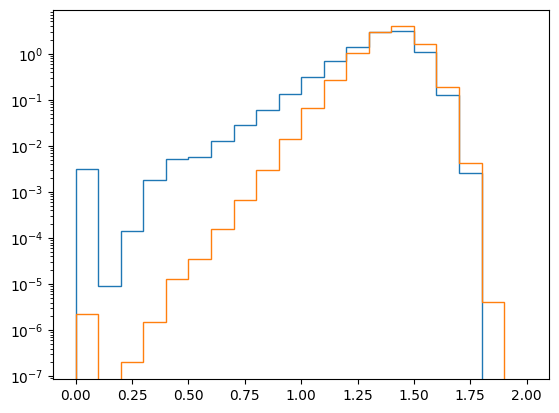

In [16]:
plt.stairs(epitope_matched_hist, epitope_matched_hist_bins)
plt.stairs(background_hist, background_hist_bins)
plt.yscale("log")
plt.show()

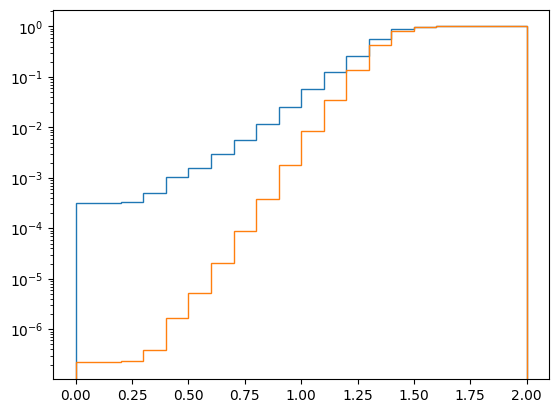

In [17]:
plt.stairs(epitope_matched_hist.cumsum() / epitope_matched_hist.sum(), epitope_matched_hist_bins)
plt.stairs(background_hist.cumsum() / background_hist.sum(), background_hist_bins)
plt.yscale("log")
plt.show()

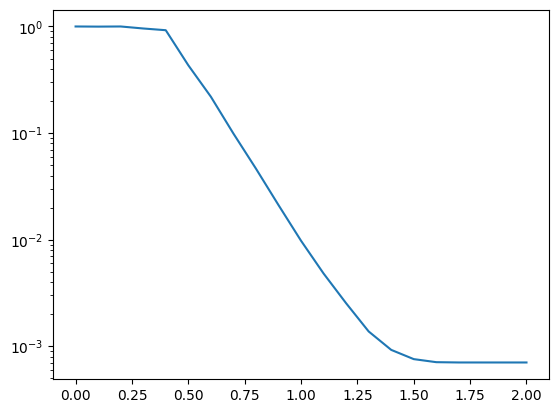

In [18]:
relative_contour = epitope_matched_hist.cumsum() / background_hist.cumsum()
relative_contour = relative_contour / relative_contour.max()

plt.plot(background_hist_bins, np.insert(relative_contour, 0, 1))
#plt.vlines(x=0.6, ymin=0, ymax=1)
plt.yscale("log")
plt.show()

### What according to the model makes TCRs similar to each other?

In [19]:
def get_all_edits_and_resulting_tcrs(tcr: pd.DataFrame):
    all_insertions_and_resulting_tcrs = get_all_insertions_and_resulting_tcrs(tcr)
    all_deletions_and_resulting_tcrs = get_all_deletions_and_resulting_tcrs(tcr)
    all_substitutions_and_resulting_tcrs = get_all_substitutions_and_resulting_tcrs(tcr)

    return all_insertions_and_resulting_tcrs + all_deletions_and_resulting_tcrs + all_substitutions_and_resulting_tcrs

def get_all_insertions_and_resulting_tcrs(tcr: pd.DataFrame) -> list:
    edits_and_resulting_tcrs = []

    junction = tcr.iloc[0]["CDR3B"]
    junction_length_after_insertion = len(junction) + 1

    for insertion_position in range(junction_length_after_insertion):
        for residue_to_insert in Residue:
            edit = AaEdit(insertion_position, junction_length_after_insertion, "null", residue_to_insert)

            new_junction = junction[:insertion_position] + residue_to_insert + junction[insertion_position:]
            
            resulting_tcr = tcr.copy()
            resulting_tcr["CDR3B"] = [new_junction]

            edits_and_resulting_tcrs.append((edit, resulting_tcr))
    
    return edits_and_resulting_tcrs

def get_all_deletions_and_resulting_tcrs(tcr: pd.DataFrame) -> list:
    edits_and_resulting_tcrs = []

    junction = tcr.iloc[0]["CDR3B"]

    for deletion_position, residue_to_delete in enumerate(junction):
        edit = AaEdit(deletion_position, len(junction), residue_to_delete, "null")

        new_junction = junction[:deletion_position] + junction[deletion_position+1:]
        
        resulting_tcr = tcr.copy()
        resulting_tcr["CDR3B"] = [new_junction]

        edits_and_resulting_tcrs.append((edit, resulting_tcr))
    
    return edits_and_resulting_tcrs

def get_all_substitutions_and_resulting_tcrs(tcr: pd.DataFrame) -> list:
    edits_and_resulting_tcrs = []

    junction = tcr.iloc[0]["CDR3B"]

    for substitution_position, residue_to_substitute_from in enumerate(junction):
        for residue_to_subtitute_to in AMINO_ACIDS:
            if residue_to_subtitute_to == residue_to_substitute_from:
                continue

            edit = AaEdit(substitution_position, len(junction), residue_to_substitute_from, residue_to_subtitute_to)

            new_junction = junction[:substitution_position] + residue_to_subtitute_to + junction[substitution_position+1:]
            
            resulting_tcr = tcr.copy()
            resulting_tcr["CDR3B"] = [new_junction]

            edits_and_resulting_tcrs.append((edit, resulting_tcr))
    
    return edits_and_resulting_tcrs

In [6]:
def investigate_effects_of_junction_edits():
    new_edit_record_collection = TcrEditRecordCollection()
    filled_edit_record_collection = fill_edit_records_with_estimates(new_edit_record_collection)
    return filled_edit_record_collection

def fill_edit_records_with_estimates(edit_record_collection: TcrEditRecordCollection) -> TcrEditRecordCollection:
    number_of_tcrs_processed = 0

    while not edit_record_collection.has_sufficient_coverage():
        tcr = get_random_tcr()
        edits_and_resulting_distances = get_all_possible_edits_and_resulting_distances(tcr)

        for edit, distance in edits_and_resulting_distances:
            edit_record_collection.update_edit_record(edit, distance)

        number_of_tcrs_processed += 1

        if (number_of_tcrs_processed % 10) == 0:
            print(f"{number_of_tcrs_processed} TCRs processed...")
            edit_record_collection.print_current_estimation_coverage()
    
    return edit_record_collection

def get_random_tcr():
    return background_df.sample()

def get_all_possible_edits_and_resulting_distances(tcr: pd.DataFrame):
    anchor_tcr_embedding = model.embed(tcr)[0]
    junction = tcr.iloc[0]["CDR3B"]
    max_junction_length_post_edit = len(junction) + 1

    edits_and_resulting_embeddings = []

    for edit_position in range(max_junction_length_post_edit):
        insertions_and_embeddings = try_all_insertions_at_position(tcr, edit_position)
        edits_and_resulting_embeddings.extend(insertions_and_embeddings)

        if edit_position < len(junction):
            deletions_and_embeddings = try_all_deletions_at_position(tcr, edit_position)
            substitutions_and_embeddings = try_all_substitutions_at_position(tcr, edit_position)

            edits_and_resulting_embeddings.extend(deletions_and_embeddings)
            edits_and_resulting_embeddings.extend(substitutions_and_embeddings)

    return [(edit, float(np.linalg.norm(anchor_tcr_embedding - resulting_tcr_embedding, ord=2))) for (edit, resulting_tcr_embedding) in edits_and_resulting_embeddings]

def try_all_insertions_at_position(tcr: pd.DataFrame, edit_index: int) -> list:
    edits_and_resulting_embeddings = []

    junction = tcr.iloc[0]["CDR3B"]
    edit_position = get_edit_position_from_edit_index(edit_index, len(junction))
    
    for residue_to_insert in tcr_edit.Residue:
        if residue_to_insert == tcr_edit.Residue.null:
            continue

        edit = TcrEdit(edit_position, tcr_edit.Residue.null, residue_to_insert)

        new_junction = junction[:edit_index] + residue_to_insert.name + junction[edit_index:]
        
        resulting_tcr = tcr.copy()
        resulting_tcr["CDR3B"] = [new_junction]

        resulting_embedding = model.embed(resulting_tcr)[0]

        edits_and_resulting_embeddings.append((edit, resulting_embedding))
    
    return edits_and_resulting_embeddings

def try_all_deletions_at_position(tcr: pd.DataFrame, edit_index: int) -> list:
    edits_and_resulting_embeddings = []

    junction = tcr.iloc[0]["CDR3B"]
    edit_position = get_edit_position_from_edit_index(edit_index, len(junction))
    residue_to_delete = tcr_edit.Residue[junction[edit_index]]

    edit = TcrEdit(edit_position, residue_to_delete, tcr_edit.Residue["null"])

    new_junction = junction[:edit_index] + junction[edit_index+1:]
    
    resulting_tcr = tcr.copy()
    resulting_tcr["CDR3B"] = [new_junction]

    resulting_embedding = model.embed(resulting_tcr)[0]

    edits_and_resulting_embeddings.append((edit, resulting_embedding))

    return edits_and_resulting_embeddings

def try_all_substitutions_at_position(tcr: pd.DataFrame, edit_index: int) -> list:
    edits_and_resulting_embeddings = []

    junction = tcr.iloc[0]["CDR3B"]
    edit_position = get_edit_position_from_edit_index(edit_index, len(junction))
    from_residue = tcr_edit.Residue[junction[edit_index]]

    for to_residue in tcr_edit.Residue:
        if to_residue == from_residue or to_residue == tcr_edit.Residue.null:
            continue

        edit = TcrEdit(edit_position, from_residue, to_residue)

        new_junction = junction[:edit_index] + to_residue.name + junction[edit_index+1:]
        
        resulting_tcr = tcr.copy()
        resulting_tcr["CDR3B"] = [new_junction]

        resulting_embedding = model.embed(resulting_tcr)[0]

        edits_and_resulting_embeddings.append((edit, resulting_embedding))
    
    return edits_and_resulting_embeddings

def get_edit_position_from_edit_index(edit_index, junction_length):
    position_enum_index = ceil(edit_index / junction_length * 5)
    if position_enum_index == 0:
        position_enum_index = 1
    return tcr_edit.Position(position_enum_index)

In [7]:
edit_records = investigate_effects_of_junction_edits()

/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


10 TCRs processed...
Number of estimates at positions:
min: 1120, max: 1520, mean: 1232.0
Number of estimates for each edit:
min: 1, max: 159, mean: 14.666666666666666
20 TCRs processed...
Number of estimates at positions:
min: 2240, max: 2840, mean: 2416.0
Number of estimates for each edit:
min: 1, max: 312, mean: 28.761904761904763
30 TCRs processed...
Number of estimates at positions:
min: 3280, max: 4240, mean: 3600.0
Number of estimates for each edit:
min: 1, max: 465, mean: 42.857142857142854
40 TCRs processed...
Number of estimates at positions:
min: 4360, max: 5520, mean: 4736.0
Number of estimates for each edit:
min: 1, max: 612, mean: 56.38095238095238
50 TCRs processed...
Number of estimates at positions:
min: 5480, max: 6920, mean: 5968.0
Number of estimates for each edit:
min: 4, max: 771, mean: 71.04761904761905
60 TCRs processed...
Number of estimates at positions:
min: 6600, max: 8240, mean: 7152.0
Number of estimates for each edit:
min: 4, max: 924, mean: 85.1428571428

In [8]:
with open("edit_records_state.pkl", "wb") as f:
    edit_records.save(f)

In [3]:
with open("edit_records_state.pkl", "rb") as f:
    state_dict = pickle.load(f)

In [4]:
new_edit_records_collection = TcrEditRecordCollection.from_state_dict(state_dict)

In [33]:
from typing import List, Set, Iterable
from itertools import permutations


class TcrEditRecordCollectionAnalyser:
    def __init__(self, tcr_edit_record_collection: TcrEditRecordCollection) -> None:
        self.edit_record_collection = tcr_edit_record_collection

    def get_average_distance_over_junction_positions(self) -> np.ndarray:
        avg_dists_over_positions = [self.get_average_distance_accross_specified_edits(edits) for edits in self.get_all_edits_over_positions()]

        return np.array(avg_dists_over_positions)
    
    def get_average_distance_over_aa_edit_types(self) -> np.ndarray:
        all_insertions = self.get_all_insertions()
        all_deletions = self.get_all_deletions()
        all_substitutions = self.get_all_substitutions()

        avg_dists_over_edit_types = [
            self.get_average_distance_accross_specified_edits(all_insertions),
            self.get_average_distance_accross_specified_edits(all_deletions),
            self.get_average_distance_accross_specified_edits(all_substitutions)
        ]
        
        return np.array(avg_dists_over_edit_types)
    
    def get_average_distance_position_edit_type_table(self) -> pd.DataFrame:
        all_insertions = self.get_all_insertions()
        all_deletions = self.get_all_deletions()
        all_substitutions = self.get_all_substitutions()

        ins_over_positions = [edits.intersection(all_insertions) for edits in self.get_all_edits_over_positions()]
        dels_over_positions = [edits.intersection(all_deletions) for edits in self.get_all_edits_over_positions()]
        subs_over_positions = [edits.intersection(all_substitutions) for edits in self.get_all_edits_over_positions()]

        ins_dists_over_positions = [self.get_average_distance_accross_specified_edits(edits) for edits in ins_over_positions]
        del_dists_over_positions = [self.get_average_distance_accross_specified_edits(edits) for edits in dels_over_positions]
        sub_dists_over_positions = [self.get_average_distance_accross_specified_edits(edits) for edits in subs_over_positions]

        return pd.DataFrame([ins_dists_over_positions, del_dists_over_positions, sub_dists_over_positions], index=["ins", "del", "sub"])
    
    def rank_indelsubs_by_average_distance(self) -> List[tuple]:
        indelsubs = permutations(tcr_edit.Residue, r=2)
        indelsubs_and_distances = [(from_residue, to_residue, self.get_average_distance_for_aa_indelsub(from_residue, to_residue)) for from_residue, to_residue in indelsubs]

        return sorted(indelsubs_and_distances, key=lambda x: x[2])
    
    def get_all_edits_over_positions(self) -> List[Set[TcrEdit]]:
        return [self.get_all_edits_at_position(position) for position in tcr_edit.Position]

    def get_all_edits_at_position(self, position: tcr_edit.Position) -> Set[TcrEdit]:
        return {edit for edit in self.edit_record_collection.edit_record_dictionary if edit.is_at(position)}
    
    def get_all_insertions(self) -> Set[TcrEdit]:
        return {edit for edit in self.edit_record_collection.edit_record_dictionary if edit.is_from(tcr_edit.Residue.null)}
    
    def get_all_deletions(self) -> Set[TcrEdit]:
        return {edit for edit in self.edit_record_collection.edit_record_dictionary if edit.is_to(tcr_edit.Residue.null)}
    
    def get_all_substitutions(self) -> Set[TcrEdit]:
        return {edit for edit in self.edit_record_collection.edit_record_dictionary if not (edit.is_from(tcr_edit.Residue.null) or edit.is_to(tcr_edit.Residue.null))}
    
    def get_average_distance_for_aa_indelsub(self, from_residue: tcr_edit.Residue, to_residue: tcr_edit.Residue) -> float:
        if from_residue == to_residue:
            return 0.0

        relevant_edits = [edit for edit in self.edit_record_collection.edit_record_dictionary if edit.is_from(from_residue) and edit.is_to(to_residue)]
        return self.get_average_distance_accross_specified_edits(relevant_edits)
    
    def get_average_distance_accross_specified_edits(self, edits: Iterable) -> float:
        edit_records = [self.edit_record_collection.edit_record_dictionary[edit] for edit in edits]

        average_distances = [edit_record.average_distance for edit_record in edit_records]
        frequencies = [edit_record.num_estimates_made for edit_record in edit_records]

        weighted_sum_of_distances = sum([distance * frequency for distance, frequency in zip(average_distances, frequencies)])
        divisor = sum(frequencies)

        return weighted_sum_of_distances / divisor

In [34]:
analyser = TcrEditRecordCollectionAnalyser(new_edit_records_collection)

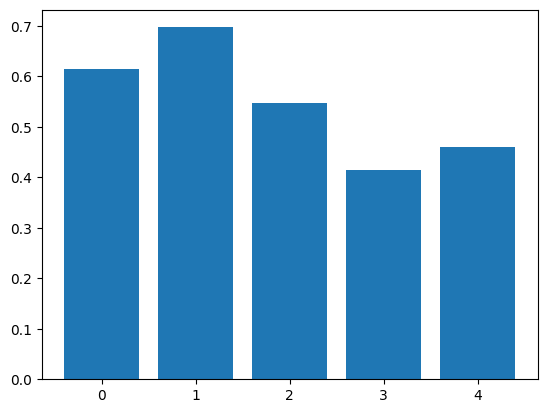

In [35]:
plt.bar(range(5), analyser.get_average_distance_over_junction_positions())
plt.show()

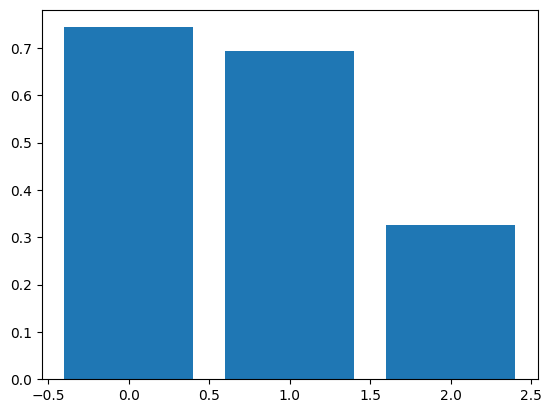

In [36]:
plt.bar(range(3), analyser.get_average_distance_over_aa_edit_types())
plt.show()

<Axes: >

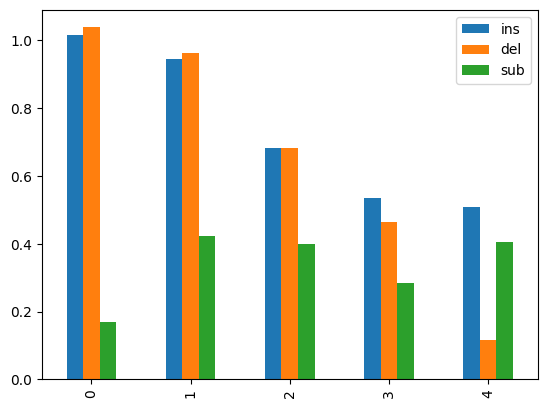

In [37]:
analyser.get_average_distance_position_edit_type_table().T.plot.bar()

In [38]:
analyser.rank_indelsubs_by_average_distance()

[(<Residues.C: 2>, <Residues.E: 4>, 0.053971144723941024),
 (<Residues.C: 2>, <Residues.A: 1>, 0.05469622641038314),
 (<Residues.C: 2>, <Residues.W: 19>, 0.05723935676952186),
 (<Residues.C: 2>, <Residues.D: 3>, 0.05741799499406153),
 (<Residues.C: 2>, <Residues.P: 13>, 0.061286299007935766),
 (<Residues.C: 2>, <Residues.I: 8>, 0.061710189669660936),
 (<Residues.C: 2>, <Residues.S: 16>, 0.06267372315381065),
 (<Residues.C: 2>, <Residues.M: 11>, 0.06418122959013048),
 (<Residues.C: 2>, <Residues.T: 17>, 0.06579935701281546),
 (<Residues.C: 2>, <Residues.V: 18>, 0.06650692855267278),
 (<Residues.C: 2>, <Residues.G: 6>, 0.06800036799790027),
 (<Residues.C: 2>, <Residues.R: 15>, 0.06813397335263296),
 (<Residues.C: 2>, <Residues.Y: 20>, 0.06863063498893389),
 (<Residues.C: 2>, <Residues.N: 12>, 0.06874847237344602),
 (<Residues.C: 2>, <Residues.L: 10>, 0.06905680325027776),
 (<Residues.C: 2>, <Residues.F: 5>, 0.07212608466249512),
 (<Residues.C: 2>, <Residues.Q: 14>, 0.07225702668891039),
